Autor: Jan Stosik

Zadanie: Case 3 - backtesting strategii inwestycyjnej

Polecenie: Strategia inwestycyjna (decyzje wejścia i wyjścia) dla spółki  Apple (AAPL), test w okresie od 01.01.2024 - 06.05.2024


In [1]:
!pip install ta backtesting scikit-learn pandas requests

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 4.8 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=9c0d74165288ea7b397cf1abe330a9bb7ff551df2cdd110f282a08d66bde42b1
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import requests
import datetime
import os
import matplotlib.pyplot as plt
from ta.trend import MACD
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from backtesting import Backtest, Strategy

# Ustawienie wyświetlania wykresów
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


# Pobieram dane ze Stooq

Można zmienić ticker żeby dać inną spółkę :)



In [14]:
def get_stooq_data(symbol="AAPL.US"):
    # Zakres: ostatnie 4 lata, aby mieć bazę do nauki modelu
    end = datetime.date(2024, 5, 7)
    start = end - datetime.timedelta(days=365*4)
    d1, d2 = start.strftime('%Y%m%d'), end.strftime('%Y%m%d')

    url = f'https://stooq.pl/q/d/l/?s={symbol}&d1={d1}&d2={d2}&i=d'
    r = requests.get(url)

    if r.status_code == 200 and "Brak danych" not in r.text:
        # Zapis do pliku tymczasowego w Colab
        with open("data.csv", "w") as f:
            f.write(r.text)

        df = pd.read_csv("data.csv", index_col='Data', parse_dates=True)
        # Mapowanie polskich nazw ze Stooq na angielskie standardy
        df = df.rename(columns={
            'Otwarcie': 'Open',
            'Najwyzszy': 'High',
            'Najnizszy': 'Low',
            'Zamkniecie': 'Close',
            'Wolumen': 'Volume'
        })
        print(f"Pobrano dane dla {symbol}. Liczba rekordów: {len(df)}")
        return df
    else:
        print("Błąd pobierania danych.")
        return None

df = get_stooq_data()
df.tail()

Pobrano dane dla AAPL.US. Liczba rekordów: 1006


,Open,High,Low,Close,Volume
Data,,,,,
2024-05-01,168.782,171.894,168.316,168.505,50621046
2024-05-02,171.699,172.600,170.088,172.217,94659779
2024-05-03,185.768,186.121,181.802,182.518,163994820
2024-05-06,181.496,183.334,179.573,180.856,78940657
2024-05-07,182.588,184.032,180.468,181.542,77670793


Inżynieria Cech (MACD + RSI)

W tej komórce generujemy wskaźniki techniczne:

**1.1. MACD: Różnica między dwiema średnimi kroczącymi (szybką i wolną). Pokazuje siłę i kierunek trendu.**

**1.2. MACD_Signal: Średnia krocząca z samej linii MACD. Jej przecięcie z MACD to klasyczny sygnał kupna/sprzedaży.**

**1.3. MACD_Diff (Histogram): Różnica między MACD a sygnałem. Gdy rośnie, trend przyspiesza; gdy maleje, rynek traci impet.**

Model uczy się rozpoznawać, czy obecne przecięcie linii faktycznie prowadzi do zysku, czy jest tylko "fałszywym alarmem".

**2.1. RSI (Relative Strength Index): Oscylator o wartościach od 0 do 100.**

Interpretacja: Powyżej 70 oznacza, że akcje są "za drogie" (wykupione), poniżej 30, że są "tanie" (wyprzedane).

**3.1. ATR (Average True Range): Mierzy, jak bardzo cena "skacze" w ciągu dnia. Nie mówi, czy będzie rosło, czy spadało, tylko jak duży jest niepokój na rynku**

In [15]:
# Obliczamy MACD
macd_indicator = MACD(close=df['Close'])
df['MACD'] = macd_indicator.macd()
df['MACD_Signal'] = macd_indicator.macd_signal()
df['MACD_Diff'] = macd_indicator.macd_diff()

# Dodajemy RSI jako filtr siły trendu
df['RSI'] = RSIIndicator(close=df['Close']).rsi()



# Target: Czy cena wzrośnie za 1 dzień? (1 = Tak, 0 = Nie)
# Model uczy się przewidywać tylko wyraźne wzrosty
df['Target'] = (df['Close'].shift(-1) > df['Close'] * 1.005).astype(int)

# Usuwamy wiersze z wartościami NaN (wynikające z obliczeń średnich kroczących)
df.dropna(inplace=True)

# Wyświetlamy cechy
features = ['MACD', 'MACD_Signal', 'MACD_Diff', 'RSI']


from ta.volatility import AverageTrueRange
atr_indicator = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'])
df['ATR'] = atr_indicator.average_true_range()
features.append('ATR') # Dodaj ATR do listy cech modelu

df[features + ['Target']].head()

,MACD,MACD_Signal,MACD_Diff,RSI,ATR,Target
Data,,,,,,
2020-06-25,2.815020,2.464404,0.350616,70.592648,0.0,0
2020-06-26,2.631789,2.497881,0.133909,59.481092,0.0,1
2020-06-29,2.616405,2.521586,0.094819,63.930284,0.0,1
2020-06-30,2.632960,2.543861,0.089100,65.439926,0.0,0
2020-07-01,2.602556,2.555600,0.046956,64.771847,0.0,0


Dzielimy dane na okres treningowy i okres testowy (zgodnie z wymogiem: od 01.01.2024). Optymalizujemy RandomForest.

In [16]:
# Podział na zbiory
train_data = df[:'2023-12-31']
test_data = df['2024-01-01':'2024-05-06']

X_train = train_data[features]
y_train = train_data['Target']

# Grid Search - szukanie najlepszych parametrów
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Najlepsze parametry modelu: {grid_search.best_params_}")

Najlepsze parametry modelu: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}


Uruchomienie backtestu

In [17]:
class MLBasedStrategy(Strategy):
    def init(self):
        # Model przewiduje na całym zbiorze testowym
        # Uwaga: w realnym handlu model przewidywałby krok po kroku
        self.preds = best_model.predict(self.data.df[features])
        self.i = 0

    def next(self):
        prediction = self.preds[self.i]
        self.i += 1

        if prediction == 1 and not self.position:
            # Kupujemy i od razu ustawiamy Stoploss i TP
            price = self.data.Close[-1]
            self.buy(sl=0.97 * price, tp=1.05 * price) # StopLoss 3%, Take Profit 5%
        elif prediction == 0 and self.position:
            self.position.close()

# Uruchomienie backtestu na danych od 2024 roku (dodanie opłat transakcyjnych)
bt = Backtest(test_data, MLBasedStrategy, cash=10000, commission=.002)
stats = bt.run()

print(stats)

Backtest.run:   0%|          | 0/86 [00:00<?, ?bar/s]

Start                     2024-01-02 00:00:00
End                       2024-05-06 00:00:00
Duration                    125 days 00:00:00
Exposure Time [%]                    14.94253
Equity Final [$]                  10095.58767
Equity Peak [$]                   10291.57793
Commissions [$]                     160.90833
Return [%]                            0.95588
Buy & Hold Return [%]                -1.99207
Return (Ann.) [%]                     2.79391
Volatility (Ann.) [%]                 5.77101
CAGR [%]                              1.93641
Sharpe Ratio                          0.48413
Sortino Ratio                         0.74023
Calmar Ratio                           1.4671
Alpha [%]                             1.04613
Beta                                  0.04531
Max. Drawdown [%]                    -1.90438
Avg. Drawdown [%]                    -1.49681
Max. Drawdown Duration       45 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                          

In [18]:
# Wyświetlenie najważniejszych metryk
print(f"Zwrot z inwestycji: {stats['Return [%]']:.2f}%")
print(f"Maksymalne obsunięcie (Drawdown): {stats['Max. Drawdown [%]']:.2f}%")
print(f"Liczba transakcji: {stats['# Trades']}")

# Generowanie wykresu (w Colab bt.plot() otworzy się w nowej karcie lub pod komórką)
bt.plot()

Zwrot z inwestycji: 0.96%
Maksymalne obsunięcie (Drawdown): -1.90%
Liczba transakcji: 4


GridPlot(id='p2037', ...)

## Porównanie strategii ML z Buy & Hold w tym samym okresie :)

 PORÓWNANIE WYNIKÓW (01.01.2024 - 06.05.2024)
Zwrot Buy & Hold (AAPL): -1.99%
Zwrot Strategii ML:      0.96%
Różnica (Alpha):         2.95%


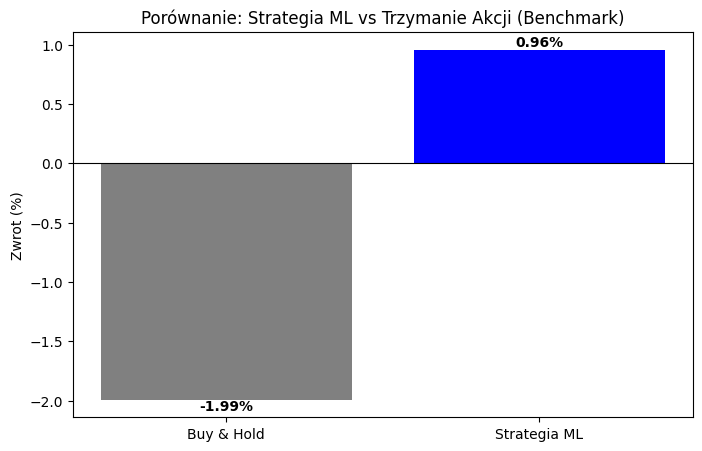

In [19]:
# Obliczenie zwrotu Buy & Hold
first_price = test_data['Close'].iloc[0]
last_price = test_data['Close'].iloc[-1]
bh_return = ((last_price - first_price) / first_price) * 100

# Pobranie zwrotu z naszej strategii ML
ml_return = stats['Return [%]']

# Wyświetlenie wyników
print(f" PORÓWNANIE WYNIKÓW (01.01.2024 - 06.05.2024)")
print(f"Zwrot Buy & Hold (AAPL): {bh_return:.2f}%")
print(f"Zwrot Strategii ML:      {ml_return:.2f}%")
print(f"Różnica (Alpha):         {ml_return - bh_return:.2f}%")


import matplotlib.pyplot as plt

labels = ['Buy & Hold', 'Strategia ML']
returns = [bh_return, ml_return]
colors = ['gray', 'blue' if ml_return > bh_return else 'red']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, returns, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Zwrot (%)')
plt.title('Porównanie: Strategia ML vs Trzymanie Akcji (Benchmark)')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", va='bottom' if yval > 0 else 'top', ha='center', fontweight='bold')

plt.show()